In [1]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc, current_mirror_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [4]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                      # LDO output voltage
Vin = 3.3                                       # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                     # Load current
CL = 1e-12                                      # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.999
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3


I_amp =10e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

# 1. Preparation

## Macromodels

In [5]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 2.5, 5)  # this will be used in the near future

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_diff_m1"), 
                                  Symbol("L_diff_m1"), 
                                  Symbol("W_diff_m2"), 
                                  Symbol("L_diff_m2"), 
                                  Symbol("W_al_m1"), 
                                  Symbol("L_al_m1"), 
                                  Symbol("W_al_m2"), 
                                  Symbol("L_al_m2"), 
                                  Symbol("W_pt"), 
                                  Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = {"max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3]}

## OTA CASCODE DIFFPAIR MACROMODEL

OTA_ccdiff = Macromodel(name = "ota_ccdiff",
                       outputs = [Symbol("W_diff_m1"), 
                                  Symbol("L_diff_m1"), 
                                  Symbol("W_diff_m2"), 
                                  Symbol("L_diff_m2"), 
                                  Symbol("W_aload_m1"), 
                                  Symbol("L_aload_m1"),
                                  Symbol("W_aload_m2"), 
                                  Symbol("L_aload_m2")],
                       req_tfs = [["vout", "vpos"], 
                                  ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={"Vdd": LDO_macro.electrical_parameters["Vdd"],
                                              "Vref": LDO_macro.electrical_parameters["Vref"],
                                              "Vout": LDO_macro.electrical_parameters["Vaout"],
                                              "I": I_amp}
                      )

OTA_ccdiff.area_conditions = {"max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3],
                              "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 5e-6, 0]}

## Primitives

### Nominal

In [12]:
## PASS TRANSISTOR PRIMITIVE ###############################################################

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': Ib_pt+IL,
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt.cgg).flatten()+np.asarray(pt.cgd).flatten()*np.asarray(pt.gm).flatten()*np.asarray(pt.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt.cgd).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## DIFF PAIR PRIMITIVE #####################################################################

sweep_size_dp = 3
vin_dp = OTA_ccdiff.electrical_parameters["Vref"]
vout_dp = OTA_ccdiff.electrical_parameters["Vout"]
vs_dp = np.linspace(0.1, vin_dp-0.1, sweep_size_dp)
vcp_dp = np.linspace(vin_dp, vout_dp-0.1, sweep_size_dp)

diffpair_primitive = diffpair_cc(vcp_dp, vs_dp, vin_dp, vout_dp, I_amp, sweep_size_dp, lengths, vout_dp + 0.5)
diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive.vbias).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

vout_cm = 1.7 - 3.3 
sweep_size_cm = 5

vcp_cm = np.linspace(vout_cm+0.1, vout_cm+1.6, sweep_size_cm)

activeload_primmitive = current_mirror_cc(vcp_cm, vout_cm, I_amp, sweep_size_cm, lengths, vout_cm - 0.5)
activeload_primmitive.build()

activeload_primmitive.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive.Ro).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive.gm).flatten(),
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive.vbias).flatten()}
activeload_primmitive.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

length
vgs
0
vds
vgs
1
M1 jd:  [[7.25617454e+01 1.80845817e+00 6.08249885e-07 7.34084543e+01
  1.90120061e+00 6.81829196e-07 7.42184014e+01 1.99635755e+00
  7.41052912e-07]
 [2.68475066e+01 4.21686384e-01 5.76879734e-08 2.70161958e+01
  4.31455662e-01 6.12480740e-08 2.71720535e+01 4.41158333e-01
  6.32482759e-08]
 [1.33920261e+01 3.20830019e-01 9.84013468e-08 1.34308666e+01
  3.24229363e-01 1.01240520e-07 1.34668188e+01 3.27472890e-01
  1.02400065e-07]
 [6.77136134e+00 2.02576492e-01 1.00439538e-07 6.78141779e+00
  2.03654438e-01 1.02074952e-07 6.79065407e+00 2.04665256e-01
  1.02550571e-07]
 [3.40715906e+00 1.13132608e-01 7.25296697e-08 3.40978209e+00
  1.13438949e-01 7.33387728e-08 3.41217923e+00 1.13727975e-01
  7.35222146e-08]]
M1 gmid:  [[ 2.69279641 14.6328196  25.30420007  2.68099255 14.43691294 25.37605575
   2.66803299 14.24215868 25.40744333]
 [ 3.30401794 16.94849873 27.22257732  3.30213304 16.87704111 27.24312789
   3.29890682 16.80351106 27.22820591]
 [ 3.25801581 14.14441

### Worst Case

In [8]:
vg_wc = -0.5349

pt_wc = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': vg_wc, 
                     'il': Ib_pt,
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt_wc.build()

pt_wc.parameters = {Symbol('gm_pt'): np.asarray(pt_wc.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt_wc.cgg).flatten()+np.asarray(pt_wc.cgd).flatten()*np.asarray(pt_wc.gm).flatten()*np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt_wc.cgd).flatten()}
pt_wc.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

diffpair_primitive_wc = diffpair_cc(vcp_dp, vs_dp, vin_dp, 3.3+vg_wc, I_amp, sweep_size_dp, lengths, vout_dp + 0.5)
diffpair_primitive_wc.build()      

diffpair_primitive_wc.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive_wc.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive_wc.gm).flatten(),
                                 Symbol("Rdif_2"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_2"): np.asarray(diffpair_primitive.gm).flatten(),}
                                 ########################
                                 #Symbol("Cgd"): np.asarray(diffpair_primitive_wc.cgd_m1).flatten(),
                                 #Symbol("Cgs"): np.asarray(diffpair_primitive_wc.cgs_m1).flatten(),
                                 #Symbol("vbias"): np.asarray(diffpair_primitive_wc.vbias).flatten(), 
                                 ########################
                                 #Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive_wc.Ro_m1).flatten(), 
                                 #Symbol("gdif_m1_1"): np.asarray(diffpair_primitive_wc.gm_m1).flatten(),
                                 #Symbol("Rdif_m1_2"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 #Symbol("gdif_m1_2"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 ########################
                                 #Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive_wc.Ro_m2).flatten(), 
                                 #Symbol("gdif_m2_1"): np.asarray(diffpair_primitive_wc.gm_m2).flatten(),
                                 #Symbol("Rdif_m2_2"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 #Symbol("gdif_m2_2"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 ########################
                                 #Symbol("Cds_m1"): np.asarray(np.abs(diffpair_primitive_wc.cds_m1)).flatten(),
                                 #Symbol("Cgs_m2"): np.asarray(np.abs(diffpair_primitive_wc.cgs_m2)).flatten(),
                                 #Symbol("Cgd_m2"): np.asarray(np.abs(diffpair_primitive_wc.cgd_m2)).flatten()}

diffpair_primitive_wc.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

activeload_primmitive_wc = current_mirror_cc(vcp_cm, vg_wc, I_amp, sweep_size_cm, lengths, vout_cm - 0.5)
activeload_primmitive_wc.build()

activeload_primmitive_wc.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive_wc.gm_m2*activeload_primmitive_wc.Ro_m2*activeload_primmitive.Ro_m1).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("Raload_2"): np.asarray(activeload_primmitive.Ro).flatten(),
                                    Symbol("gaload_2"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive_wc.vbias).flatten()}

activeload_primmitive_wc.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

length
vgs
0
vds
vgs
1
M1 jd:  [[7.25617454e+01 1.80845817e+00 6.08249885e-07 7.34084543e+01
  1.90120061e+00 6.81829196e-07 7.42184014e+01 1.99635755e+00
  7.41052912e-07]
 [2.68475066e+01 4.21686384e-01 5.76879734e-08 2.70161958e+01
  4.31455662e-01 6.12480740e-08 2.71720535e+01 4.41158333e-01
  6.32482759e-08]
 [1.33920261e+01 3.20830019e-01 9.84013468e-08 1.34308666e+01
  3.24229363e-01 1.01240520e-07 1.34668188e+01 3.27472890e-01
  1.02400065e-07]
 [6.77136134e+00 2.02576492e-01 1.00439538e-07 6.78141779e+00
  2.03654438e-01 1.02074952e-07 6.79065407e+00 2.04665256e-01
  1.02550571e-07]
 [3.40715906e+00 1.13132608e-01 7.25296697e-08 3.40978209e+00
  1.13438949e-01 7.33387728e-08 3.41217923e+00 1.13727975e-01
  7.35222146e-08]]
M1 gmid:  [[ 2.69279641 14.6328196  25.30420007  2.68099255 14.43691294 25.37605575
   2.66803299 14.24215868 25.40744333]
 [ 3.30401794 16.94849873 27.22257732  3.30213304 16.87704111 27.24312789
   3.29890682 16.80351106 27.22820591]
 [ 3.25801581 14.14441

### Load Regulation Case

In [13]:
vg_loadreg = -0.651

pt_loadreg = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': vg_wc, 
                     'il': Ib_pt+Vout/(RL+1800),
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt_loadreg.build()

pt_loadreg.parameters = {Symbol('gm_pt'): np.asarray(pt_loadreg.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt_loadreg.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt_loadreg.cgg).flatten()+np.asarray(pt_loadreg.cgd).flatten()*np.asarray(pt_loadreg.gm).flatten()*np.asarray(pt_loadreg.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt_loadreg.cgd).flatten()}
pt_loadreg.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

diffpair_primitive_loadreg = diffpair_cc(vcp_dp, vs_dp, vin_dp, 3.3+vg_wc, I_amp, sweep_size_dp, lengths, vout_dp + 0.5)
diffpair_primitive_loadreg.build()      

diffpair_primitive_loadreg.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive_loadreg.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive_loadreg.gm).flatten(),
                                 Symbol("Rdif_2"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_2"): np.asarray(diffpair_primitive.gm).flatten(),
                                 ########################
                                 Symbol("Cgd"): np.asarray(diffpair_primitive_loadreg.cgd_m1).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive_loadreg.cgs_m1).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive_loadreg.vbias).flatten(), 
                                 ########################
                                 Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive_loadreg.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_1"): np.asarray(diffpair_primitive_loadreg.gm_m1).flatten(),
                                 Symbol("Rdif_m1_2"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_2"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 ########################
                                 Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive_loadreg.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_1"): np.asarray(diffpair_primitive_loadreg.gm_m2).flatten(),
                                 Symbol("Rdif_m2_2"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_2"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 ########################
                                 Symbol("Cds_m1"): np.asarray(np.abs(diffpair_primitive_loadreg.cds_m1)).flatten(),
                                 Symbol("Cgs_m2"): np.asarray(np.abs(diffpair_primitive_loadreg.cgs_m2)).flatten(),
                                 Symbol("Cgd_m2"): np.asarray(np.abs(diffpair_primitive_loadreg.cgd_m2)).flatten()}

diffpair_primitive_loadreg.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load ################################################################

activeload_primmitive_loadreg = current_mirror_cc(vcp_cm, vg_wc, I_amp, sweep_size_cm, lengths, vout_cm - 0.5)
activeload_primmitive_loadreg.build()

activeload_primmitive_loadreg.parameters = {Symbol("Raload_1"): np.asarray(activeload_primmitive_loadreg.gm_m2*activeload_primmitive_loadreg.Ro_m2*activeload_primmitive.Ro_m1).flatten(),
                                    Symbol("gaload"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("Raload_2"): np.asarray(activeload_primmitive.Ro).flatten(),
                                    Symbol("gaload_2"): np.asarray(activeload_primmitive.gm).flatten(),
                                    ########################
                                    Symbol("vbias_cm"): np.asarray(activeload_primmitive_loadreg.vbias).flatten()}

activeload_primmitive_loadreg.outputs = {Symbol("W_aload_m1"): np.asarray(activeload_primmitive.W_m1).flatten(),
                                 Symbol("L_aload_m1"): np.asarray(activeload_primmitive.L_m1).flatten(),
                                 Symbol("W_aload_m2"): np.asarray(activeload_primmitive.W_m2).flatten(),
                                 Symbol("L_aload_m2"): np.asarray(activeload_primmitive.L_m2).flatten()}

length
vgs
0
vds
vgs
1
M1 jd:  [[7.25617454e+01 1.80845817e+00 6.08249885e-07 7.34084543e+01
  1.90120061e+00 6.81829196e-07 7.42184014e+01 1.99635755e+00
  7.41052912e-07]
 [2.68475066e+01 4.21686384e-01 5.76879734e-08 2.70161958e+01
  4.31455662e-01 6.12480740e-08 2.71720535e+01 4.41158333e-01
  6.32482759e-08]
 [1.33920261e+01 3.20830019e-01 9.84013468e-08 1.34308666e+01
  3.24229363e-01 1.01240520e-07 1.34668188e+01 3.27472890e-01
  1.02400065e-07]
 [6.77136134e+00 2.02576492e-01 1.00439538e-07 6.78141779e+00
  2.03654438e-01 1.02074952e-07 6.79065407e+00 2.04665256e-01
  1.02550571e-07]
 [3.40715906e+00 1.13132608e-01 7.25296697e-08 3.40978209e+00
  1.13438949e-01 7.33387728e-08 3.41217923e+00 1.13727975e-01
  7.35222146e-08]]
M1 gmid:  [[ 2.69279641 14.6328196  25.30420007  2.68099255 14.43691294 25.37605575
   2.66803299 14.24215868 25.40744333]
 [ 3.30401794 16.94849873 27.22257732  3.30213304 16.87704111 27.24312789
   3.29890682 16.80351106 27.22820591]
 [ 3.25801581 14.14441

## Testbenches

In [ ]:
#################### PSRR LDO MACRO #######################
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo_psrr"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [1]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### DC #######################
dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo_dc"
dc_LDO_macro.parametros = {Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"max": [1]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = Test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                           Symbol("V2"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("Cc"): 1e-12,
                           Symbol("R1"): 100000,
                           Symbol("R2"): 300000}

bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = Test()
loadreg_LDO_macro.name = 'loadreg_LDO'
loadreg_LDO_macro.tf = ["vout", "vdd"]
loadreg_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 3.3,
                                Symbol("V2"): 1.35,
                                Symbol("s"): 0,
                                Symbol("Cl"): CL,
                                Symbol("Cc"): 1e-12,
                                Symbol("R1"): 100000,
                                Symbol("R2"): 300000}

loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

##################### OPENLOOP ######################################

ol_gain_LDO_macro = Test()
ol_gain_LDO_macro.name = "ol_gain_LDO"
ol_gain_LDO_macro.tf = ["vout", "vol"]
ol_gain_LDO_macro.netlist = "ldo_ol"
ol_gain_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

ol_gain_LDO_macro.opt_goal = "min"
ol_gain_LDO_macro.conditions = {"min": [1]}
ol_gain_LDO_macro.variables = {}
ol_gain_LDO_macro.out_def = {"eval": ol_gain_LDO_macro.tf}

##################### OPENLOOP ######################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): 100000, 
                             Symbol("R2"): 300000,
                             Symbol("R4"): 100000000,
                             Symbol("C2"): 10}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [1]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

###############################################################################################################################

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cap"
psrr_1stage_OTA.parametros = {Symbol("gaload_2"): Symbol("gaload"),
                              Symbol("Raload_2"): Symbol("Raload_1"),
                              Symbol("gdif_2"): Symbol("gdif_1"), 
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                              Symbol("V1"): 0,
                              Symbol("V_b"): 0,
                              Symbol("V_n"): 0,
                              Symbol("V_p"): 1,
                              Symbol("I2"): 0,
                              Symbol("s"): 0,
                              Symbol("Cl"): 1e-12}

psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = Test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.name = "bw_1stage"
bw_1stage_OTA.netlist = "ota_cap_cc"
bw_1stage_OTA.parametros = {Symbol("gdif_m1_2"): Symbol("gdif_m1_1"),
                              Symbol("gdif_m2_2"): Symbol("gdif_m2_1"),
                                Symbol("Rdif_m1_2"): Symbol("Rdif_m1_1"),
                                Symbol("Rdif_m2_2"): Symbol("Rdif_m2_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V_b"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 1,
                                Symbol("I2"): 0,
                                Symbol("Cl"): 1e-12}

bw_1stage_OTA.conditions = {"min": [1]}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"frec": [bw_1stage_OTA.tf, -0.70794]}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

#################### gm 1 stage OTA #######################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [0.00000001]}

# 2. Build OTA

## Exploration

### Worst Case

In [175]:
psrr_1stage_OTA.conditions = {"min": [50]}

OTA_ccdiff.ext_mask = None

OTA_ccdiff.primitives = [diffpair_primitive_wc, activeload_primmitive_wc]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = -1
OTA_ccdiff.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA]
OTA_ccdiff.is_primitive = 0

ota1_results_wc, ota1_axes_wc, ota1_primouts_wc, ota1_df_wc, mask = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2a9e0100>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2aa07d30>
eval:  [nan nan nan ... nan nan nan]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2a9e0100>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2aa07d30>
eval:  [nan nan nan ... nan nan nan]
found numerator with index:  0
found denominator wit

### Nominal

In [176]:
OTA_ccdiff.ext_mask = mask
psrr_1stage_OTA.conditions = {"min": [1]}

OTA_ccdiff.primitives = [diffpair_primitive, activeload_primmitive]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = -1
OTA_ccdiff.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA]
OTA_ccdiff.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df, _ = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2a7faf50>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2a7f8940>
eval:  [         nan 582.38219665 349.76618143 ...          nan          nan
          nan]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2a7faf50>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2a7f8940>
eval:  [              nan 21654285

### Load reg case

In [177]:
OTA_ccdiff.ext_mask = mask
psrr_1stage_OTA.conditions = {"min": [1]}

OTA_ccdiff.primitives = [diffpair_primitive_loadreg, activeload_primmitive_loadreg]
OTA_ccdiff.submacromodels = []
OTA_ccdiff.num_level_exp = -1
OTA_ccdiff.specifications = [psrr_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_ccdiff.opt_specifications = [psrr_1stage_OTA]
OTA_ccdiff.is_primitive = 0

ota1_results_loadreg, ota1_axes_loadreg, ota1_primouts_loadreg, ota1_df_loadreg, _ = dfs(OTA_ccdiff, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  ota_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7
[['vout', 'vr']]
Netlist:  ota_cap
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2aa3e4d0>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2aa0c970>
eval:  [nan nan nan ... nan nan nan]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.diffpair_cc object at 0x7f8f2aa3e4d0>
mod:  <sstadex.models.primitives.current_mirror_cc object at 0x7f8f2aa0c970>
eval:  [nan nan nan ... nan nan nan]
found numerator with index:  0
found denominator wit

## Plot

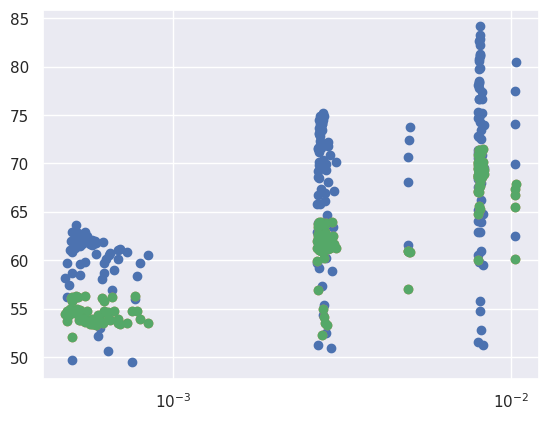

In [178]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])
ota1_df_wc["gain"]=20*np.log10(ota1_df_wc["psrr_1stage"])
ota1_df_loadreg["gain"]=20*np.log10(ota1_df_loadreg["psrr_1stage"])

area = ota1_df["area"]
gain = ota1_df["gain"]

area_wc = ota1_df_wc["area"]
gain_wc = ota1_df_wc["gain"]

area_loadreg = ota1_df_loadreg["area"]
gain_loadreg = ota1_df_loadreg["gain"]

plt.scatter(area, gain)
plt.scatter(area_wc, gain_wc)
plt.scatter(area_loadreg, gain_loadreg)
plt.xscale("log")

In [179]:
m1 = (ota1_df_wc['gain']>50) & (ota1_df['gain']>70)

ota1_df = ota1_df.sort_values(by=["area"])
ota1_df = ota1_df[m1]
ota1_df_wc = ota1_df_wc.sort_values(by=["area"])
ota1_df_wc = ota1_df_wc[m1]
ota1_df_loadreg = ota1_df_loadreg.sort_values(by=["area"])
ota1_df_loadreg = ota1_df_loadreg[m1]

/tmp/ipykernel_43742/622050953.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota1_df = ota1_df[m1]
/tmp/ipykernel_43742/622050953.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota1_df_wc = ota1_df_wc[m1]
/tmp/ipykernel_43742/622050953.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota1_df_loadreg = ota1_df_loadreg[m1]


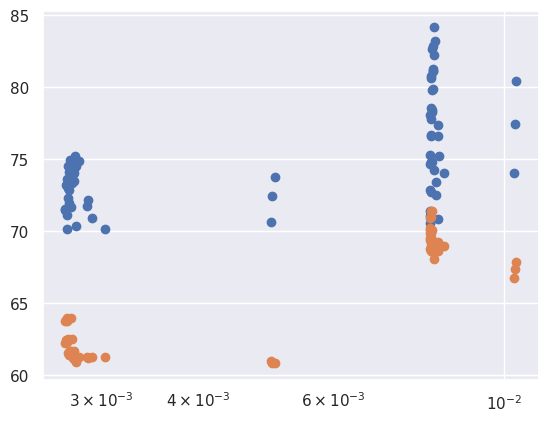

In [180]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])
ota1_df_wc["gain"]=20*np.log10(ota1_df_wc["psrr_1stage"])
ota1_df_loadreg["gain"]=20*np.log10(ota1_df_loadreg["psrr_1stage"])

area = ota1_df["area"]
gain = ota1_df["gain"]

area_wc = ota1_df_wc["area"]
gain_wc = ota1_df_wc["gain"]

area_loadreg = ota1_df_loadreg["area"]
gain_loadreg = ota1_df_loadreg["gain"]

plt.scatter(area, gain)
plt.scatter(area_wc, gain_wc)
#plt.scatter(area_loadreg, gain_loadreg)
plt.xscale("log")

## Comparation

In [164]:
W_diff_m1 = ota1_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df[Symbol("L_diff_m2")].values*1e6

W_al_m1 = ota1_df[Symbol("W_aload_m1")].values*1e6
L_al_m1 = ota1_df[Symbol("L_aload_m1")].values*1e6

W_al_m2 = ota1_df[Symbol("W_aload_m2")].values*1e6
L_al_m2 = ota1_df[Symbol("L_aload_m2")].values*1e6

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_m1):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM8": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias_dp": ota1_df[Symbol("vbias")].values,
    "Vbias_cm": ota1_df[Symbol("vbias_cm")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc_full", values)

[array([23.71430613, 31.16915315, 31.16915315, 23.71430613, 30.84236392,
       23.17735259, 31.16915315, 49.36406936, 30.84236392, 49.10278458,
       49.36406936, 49.10278458, 49.36406936, 23.17735259, 49.10278458,
       30.84236392, 88.39184516, 88.15314357, 88.39184516, 49.10278458,
       88.15314357, 88.39184516, 87.92911333, 88.15314357, 88.15314357,
       87.92911333, 87.92911333, 87.92911333, 87.92911333, 31.16915315,
       49.36406936, 88.39184516,  5.52957218, 23.71430613, 23.71430613,
       31.16915315, 23.17735259, 30.84236392, 31.16915315, 23.71430613,
       30.84236392, 23.17735259, 31.16915315, 49.36406936, 30.84236392,
       49.10278458, 49.36406936, 49.10278458, 49.36406936, 23.17735259,
       49.10278458, 30.84236392, 88.39184516, 88.15314357, 88.39184516,
       49.10278458, 88.15314357, 88.39184516, 87.92911333, 88.15314357,
       88.15314357, 48.86027157, 48.86027157, 87.92911333, 48.86027157,
       87.92911333, 87.92911333, 87.92911333, 31.16915315, 49.3

In [166]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df["gain_sim"]=gain_error
ota1_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df["gain"].values)/np.asarray(gain_error))*100

ota1_df

,Rdif_1,gdif_1,vbias,Raload_1,gaload,vbias_cm,psrr_1stage,rout_1stage,gm_1stage,W_diff_m1,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain,gain_sim,gain_error
103,3.864646e+07,0.000169,2.200,5.306967e+07,0.000015,-0.88125,3787.564501,2.238189e+07,0.000169,0.000024,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,71.567201,71.758910,0.267158
91,5.304206e+07,0.000141,2.200,5.306967e+07,0.000015,-0.88125,3749.788940,2.654513e+07,0.000141,0.000031,...,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,71.480136,71.685903,0.287039
106,8.214369e+07,0.000141,2.200,5.306967e+07,0.000015,-0.88125,4557.266597,3.225394e+07,0.000141,0.000031,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,73.174089,73.554937,0.517774
118,6.077527e+07,0.000169,2.200,5.306967e+07,0.000015,-0.88125,4798.540851,2.834688e+07,0.000169,0.000024,...,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,73.622184,73.912617,0.392941
92,4.938363e+07,0.000141,2.200,5.306967e+07,0.000015,-0.88125,3609.878642,2.559799e+07,0.000141,0.000031,...,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,71.149852,71.598114,0.626081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,6.399565e+07,0.000121,2.200,1.842210e+08,0.000015,-0.88125,5750.104517,4.752173e+07,0.000121,0.000088,...,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,75.193515,76.632011,1.877148
194,5.357605e+07,0.000121,2.200,1.842210e+08,0.000015,-0.88125,5024.819069,4.153195e+07,0.000121,0.000088,...,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,74.022409,75.190010,1.552868
134,4.409935e+07,0.000141,1.775,1.842210e+08,0.000015,-0.88125,5031.883425,3.560948e+07,0.000141,0.000031,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,74.034611,74.263443,0.308135
136,8.594633e+07,0.000127,1.775,1.842210e+08,0.000015,-0.88125,7470.630605,5.862834e+07,0.000127,0.000049,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,77.467145,77.761665,0.378746


In [167]:
W_diff_m1 = ota1_df_wc[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df_wc[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df_wc[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df_wc[Symbol("L_diff_m2")].values*1e6

W_al_m1 = ota1_df_wc[Symbol("W_aload_m1")].values*1e6
L_al_m1 = ota1_df_wc[Symbol("L_aload_m1")].values*1e6

W_al_m2 = ota1_df_wc[Symbol("W_aload_m2")].values*1e6
L_al_m2 = ota1_df_wc[Symbol("L_aload_m2")].values*1e6

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_m1):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_m1,
        L_al_m1,
        mult_al,
        "pfet",
    ],
    "XM7": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "XM8": [
        W_al_m2,
        L_al_m2,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), I_amp*2),
    "Vbias_dp": ota1_df_wc[Symbol("vbias")].values,
    "Vbias_cm": ota1_df_wc[Symbol("vbias_cm")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc_full_wc", values)

[array([23.71430613, 31.16915315, 31.16915315, 23.71430613, 30.84236392,
       23.17735259, 31.16915315, 49.36406936, 30.84236392, 49.10278458,
       49.36406936, 49.10278458, 49.36406936, 23.17735259, 49.10278458,
       30.84236392, 88.39184516, 88.15314357, 88.39184516, 49.10278458,
       88.15314357, 88.39184516, 87.92911333, 88.15314357, 88.15314357,
       87.92911333, 87.92911333, 87.92911333, 87.92911333, 31.16915315,
       49.36406936, 88.39184516,  5.52957218, 23.71430613, 23.71430613,
       31.16915315, 23.17735259, 30.84236392, 31.16915315, 23.71430613,
       30.84236392, 23.17735259, 31.16915315, 49.36406936, 30.84236392,
       49.10278458, 49.36406936, 49.10278458, 49.36406936, 23.17735259,
       49.10278458, 30.84236392, 88.39184516, 88.15314357, 88.39184516,
       49.10278458, 88.15314357, 88.39184516, 87.92911333, 88.15314357,
       88.15314357, 48.86027157, 48.86027157, 87.92911333, 48.86027157,
       87.92911333, 87.92911333, 87.92911333, 31.16915315, 49.3

In [168]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df_wc["gain_sim"]=gain_error
ota1_df_wc["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df_wc["gain"].values)/np.asarray(gain_error))*100

ota1_df_wc

,Rdif_1,gdif_1,Rdif_2,gdif_2,Cgd,Cgs,vbias,Rdif_m1_1,gdif_m1_1,Rdif_m1_2,...,W_diff_m2,L_diff_m2,W_aload_m1,L_aload_m1,W_aload_m2,L_aload_m2,area,gain,gain_sim,gain_error
103,1.919585e+08,0.000169,3.864646e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002687,63.777178,63.658374,0.186628
91,2.097373e+08,0.000141,5.304206e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000005,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002690,62.241409,62.269739,0.045495
106,4.080110e+08,0.000141,8.214369e+07,0.000141,-3.156878e-16,9.253736e-14,2.200,1.121489e+06,0.000141,1.121489e+06,...,0.000010,3.200000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002696,62.428231,62.446124,0.028653
118,3.751637e+08,0.000169,6.077527e+07,0.000169,-2.883508e-16,2.978944e-14,2.200,5.276312e+05,0.000169,5.276312e+05,...,0.000018,6.400000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002699,63.981683,63.852716,0.201975
92,2.425811e+08,0.000141,4.938363e+07,0.000141,-3.176657e-16,9.157720e-14,2.200,1.225006e+06,0.000141,1.225006e+06,...,0.000017,1.600000e-06,0.000007,0.000006,0.002636,8.000000e-07,0.002701,62.278772,62.358686,0.128152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,2.577368e+09,0.000121,6.399565e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000167,3.200000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008241,68.901356,68.710467,0.277816
194,5.059918e+09,0.000121,5.357605e+07,0.000121,-5.889066e-16,1.165967e-12,2.200,5.344207e+06,0.000121,5.344207e+06,...,0.000275,6.400000e-06,0.000007,0.000006,0.007962,1.600000e-06,0.008353,68.939547,68.743646,0.284973
134,4.525273e+07,0.000141,4.409935e+07,0.000141,-3.156878e-16,9.253736e-14,1.775,1.121489e+06,0.000141,1.121489e+06,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010302,66.727242,66.631934,0.143037
136,8.819417e+07,0.000127,8.594633e+07,0.000127,-4.054649e-16,3.163520e-13,1.775,2.185698e+06,0.000127,2.185698e+06,...,0.002292,4.000000e-07,0.000007,0.000006,0.007962,1.600000e-06,0.010322,67.394784,67.253442,0.210163


# 3. Build LDO

## Exploration

### Worst case

In [295]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): 100000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): 3.3,Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                             Symbol("s"): 0,
                             Symbol("Rl"): 1000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

In [296]:
W_diff_m1 = ota1_df_wc[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df_wc[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df_wc[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df_wc[Symbol("L_diff_m2")].values

W_al_m1 = (ota1_df_wc[Symbol("W_aload_m1")].values)
L_al_m1 = (ota1_df_wc[Symbol("L_aload_m1")].values)

W_al_m2 = (ota1_df_wc[Symbol("W_aload_m2")].values)
L_al_m2 = (ota1_df_wc[Symbol("L_aload_m2")].values)

gm_OTA_ccdiff = ota1_df_wc["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df_wc["rout_1stage"].values


OTA_primitive_wc = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol("vbias"): ota1_df_wc[Symbol("vbias")],
                                  Symbol("vbias_cm"): ota1_df_wc[Symbol("vbias_cm")]})
OTA_primitive_wc.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al_m1"): W_al_m1,
                         Symbol("L_al_m1"): L_al_m1,
                         Symbol("W_al_m2"): W_al_m2,
                         Symbol("L_al_m2"): L_al_m2}

In [297]:
LDO_macro.ext_mask = None

LDO_macro.primitives=[OTA_primitive_wc, pt_wc]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=-1
LDO_macro.specifications=[psrr_LDO_macro, dc_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results_wc, ldo_axes_wc, ldo_primouts_wc, ldo_df_wc, mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_dc
Netlist:  ldo_psrr
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0
[['vout', 'vdd']]
Netlist:  ldo_dc
Running MNA... 
   vdd  vout  net1  vfb  vss  vpos
0    1     2     3    4    0     5
[['vout', 'vdd']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.Primitive object at 0x7f8f20be3f10>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f8f2a9e0070>
eval:  [0.00086837 0.00103632 0.00101427 0.00084817 0.00103187 0.00086791
 0.00100288 0.00112516 0.00101283 0.001144   0.0011126  0.00112195
 0.00110612 0.00084965 0.0011114  0.00100294 0.00117083 0.00118069
 0.00116396 0.00110592 0.00116884 0.00116042 0.00121115 0.00116317
 0.00116023 0.00116601 0.00117586 0.00116184 0.00115973 0.00120125
 0.00121904 0.00122219 0.00044744 0.00042118 0.00038215 0.00045371
 0.00041472 0.00048803 0.00043171 0.00036198 0.00044832 0.00037964
 0.00042034 0.00047888 0.00042

### Nominal

In [299]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): 3.3,Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                             Symbol("s"): 0,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

In [300]:
W_diff_m1 = ota1_df[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df[Symbol("L_diff_m2")].values

W_al_m1 = (ota1_df[Symbol("W_aload_m1")].values)
L_al_m1 = (ota1_df[Symbol("L_aload_m1")].values)

W_al_m2 = (ota1_df[Symbol("W_aload_m2")].values)
L_al_m2 = (ota1_df[Symbol("L_aload_m2")].values)

gm_OTA_ccdiff = ota1_df["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df["rout_1stage"].values

OTA_primitive = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol("vbias"): ota1_df[Symbol("vbias")],
                                  Symbol("vbias_cm"): ota1_df[Symbol("vbias_cm")]})
OTA_primitive.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al_m1"): W_al_m1,
                         Symbol("L_al_m1"): L_al_m1,
                         Symbol("W_al_m2"): W_al_m2,
                         Symbol("L_al_m2"): L_al_m2}

In [301]:
LDO_macro.ext_mask = mask

LDO_macro.primitives=[OTA_primitive, pt]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=1
LDO_macro.specifications=[psrr_LDO_macro, dc_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results, ldo_axes, ldo_primouts, ldo_df, _, final_mask = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_dc
Netlist:  ldo_psrr
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0
[['vout', 'vdd']]
Netlist:  ldo_dc
Running MNA... 
   vdd  vout  net1  vfb  vss  vpos
0    1     2     3    4    0     5
[['vout', 'vdd']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.Primitive object at 0x7f8f2122d300>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f8f2aa3dae0>
eval:  [3.61363554e-04 3.65003527e-04 3.00336667e-04 2.85236879e-04
 3.79148494e-04 4.26577871e-04 2.57419523e-04 3.06328651e-04
 3.30967535e-04 3.46214254e-04 2.69517516e-04 3.11375395e-04
 2.45087606e-04 3.57971971e-04 2.84682412e-04 2.93811797e-04
 2.69829371e-04 2.90267284e-04 2.49691083e-04 2.64097819e-04
 2.71541942e-04 2.36326317e-04 4.16231226e-04 2.57195011e-04
 2.46131291e-04 3.53580680e-04 3.36721968e-04 3.89865883e-04
 4.24233959e-04 4.02017152e-04 3.27398677e-04 2.81356257e-04
 3.81954976

### Load reg case

In [302]:
W_diff_m1 = ota1_df_loadreg[Symbol("W_diff_m1")].values
L_diff_m1 = ota1_df_loadreg[Symbol("L_diff_m1")].values

W_diff_m2 = ota1_df_loadreg[Symbol("W_diff_m2")].values
L_diff_m2 = ota1_df_loadreg[Symbol("L_diff_m2")].values

W_al_m1 = (ota1_df_loadreg[Symbol("W_aload_m1")].values)
L_al_m1 = (ota1_df_loadreg[Symbol("L_aload_m1")].values)

W_al_m2 = (ota1_df_loadreg[Symbol("W_aload_m2")].values)
L_al_m2 = (ota1_df_loadreg[Symbol("L_aload_m2")].values)

gm_OTA_ccdiff = ota1_df_loadreg["gm_1stage"].values
Ro_OTA_ccdiff = ota1_df_loadreg["rout_1stage"].values

OTA_primitive_loadreg = Primitive(parameters={Symbol("Ra"): Ro_OTA_ccdiff,
                                  Symbol("gma"): gm_OTA_ccdiff,
                                  Symbol("vbias"): ota1_df_loadreg[Symbol("vbias")],
                                  Symbol("vbias_cm"): ota1_df_loadreg[Symbol("vbias_cm")]})
OTA_primitive_loadreg.outputs = {Symbol("W_diff_m1"): W_diff_m1,
                         Symbol("L_diff_m1"): L_diff_m1,
                         Symbol("W_diff_m2"): W_diff_m2,
                         Symbol("L_diff_m2"): L_diff_m2,
                         Symbol("W_al_m1"): W_al_m1,
                         Symbol("L_al_m1"): L_al_m1,
                         Symbol("W_al_m2"): W_al_m2,
                         Symbol("L_al_m2"): L_al_m2}

In [303]:
LDO_macro.ext_mask = mask

LDO_macro.primitives=[OTA_primitive_loadreg, pt_loadreg]
LDO_macro.submacromodels=[]
LDO_macro.num_level_exp=-1
LDO_macro.specifications=[psrr_LDO_macro, dc_LDO_macro]
LDO_macro.opt_specifications=[psrr_LDO_macro]
LDO_macro.is_primitive=0

ldo_results_loadreg, ldo_axes_loadreg, ldo_primouts_loadreg, ldo_df_loadreg, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_dc
Netlist:  ldo_psrr
Running MNA... 
   vdd  vout  net1  vfb  vss
0    1     2     3    4    0
[['vout', 'vdd']]
Netlist:  ldo_dc
Running MNA... 
   vdd  vout  net1  vfb  vss  vpos
0    1     2     3    4    0     5
[['vout', 'vdd']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.primitives.Primitive object at 0x7f8f2912d3c0>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f8f2aa3e440>
eval:  [0.00086671 0.00103395 0.001012   0.00084658 0.00102953 0.00086625
 0.00100066 0.00112237 0.00101057 0.00114112 0.00110988 0.00111918
 0.00110343 0.00084806 0.00110868 0.00100073 0.00116781 0.00117762
 0.00116098 0.00110323 0.00116583 0.00115745 0.00120793 0.00116019
 0.00115726 0.00116302 0.00117282 0.00115887 0.00115677 0.00119808
 0.00121577 0.0012189  0.000447   0.00042079 0.00038183 0.00045326
 0.00041434 0.00048751 0.0004313  0.00036169 0.00044788 0.00037932
 0.00041995 0.00047837 0.00042

In [304]:
ldo_df_loadreg = ldo_df_loadreg[final_mask]
ldo_df_wc = ldo_df_wc[final_mask]

In [309]:
ldo_df['loadreg'] = np.abs(ldo_df["dc_LDO"]*3.3-ldo_df_wc["dc_LDO"]*3.3)

In [162]:
ldo_df_wc = ldo_df_wc[final_mask]

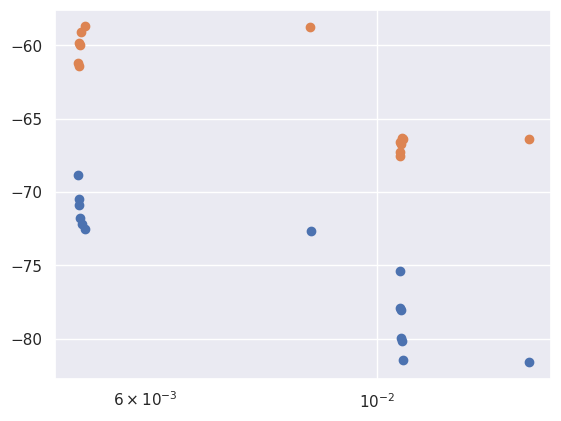

In [310]:
ldo_df["gain"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df_wc["gain"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

area = ldo_df["area"]
psrr = ldo_df["gain"]

area_wc = ldo_df_wc["area"]
psrr_wc = ldo_df_wc["gain"]

plt.scatter(area, psrr)
plt.scatter(area_wc, psrr_wc)
plt.xscale("log")

In [311]:
ldo_df

,Ra,gma,vbias,vbias_cm,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,dc_LDO,...,L_diff_m2,W_al_m1,L_al_m1,W_al_m2,L_al_m2,W_pt,L_pt,area,gain,loadreg
0,2.238189e+07,0.000169,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000361,0.545753,...,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005178,-68.841113,0.001832
2,3.225394e+07,0.000141,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000300,0.545703,...,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005186,-70.447833,0.002472
3,2.834688e+07,0.000169,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000285,0.545690,...,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005189,-70.895886,0.001974
6,3.762612e+07,0.000141,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000257,0.545667,...,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005198,-71.787170,0.002553
12,4.383643e+07,0.000127,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000245,0.545657,...,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005218,-72.213573,0.002921
21,4.783125e+07,0.000121,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000236,0.545650,...,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002490,4.000000e-07,0.005260,-72.529758,0.003121
38,5.683537e+07,0.000141,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000170,0.545595,...,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010513,-75.372197,0.000936
42,7.595345e+07,0.000141,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000127,0.545560,...,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010525,-77.891980,0.001016
46,8.567391e+07,0.000127,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000125,0.545558,...,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010533,-78.036839,0.001172
48,1.063941e+08,0.000127,2.2,-0.88125,0.186011,201.852355,4.649467e-12,4.027684e-14,0.000101,0.545538,...,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002490,4.000000e-07,0.010545,-79.918832,0.001217


In [312]:
ldo_df_wc

,Ra,gma,vbias,vbias_cm,gm_pt,Ro_pt,Cgs_pt,Cgd,psrr_LDO,dc_LDO,...,W_diff_m2,L_diff_m2,W_al_m1,L_al_m1,W_al_m2,L_al_m2,W_pt,L_pt,area,gain
0,9.148588e+06,0.000169,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000868,0.546309,...,0.000010,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005175,-61.225866
2,9.384518e+06,0.000141,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001014,0.546452,...,0.000010,0.000003,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005184,-59.876957
3,9.365728e+06,0.000169,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000848,0.546289,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005187,-61.430365
6,9.490725e+06,0.000141,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001003,0.546441,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005195,-59.975058
12,9.545842e+06,0.000127,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001106,0.546542,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005215,-59.123959
21,9.573972e+06,0.000121,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.001160,0.546596,...,0.000018,0.000006,0.000007,0.000006,0.002636,8.000000e-07,0.002488,4.000000e-07,0.005258,-58.707731
38,2.200269e+07,0.000141,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000432,0.545879,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002488,4.000000e-07,0.010511,-67.296221
42,2.259680e+07,0.000141,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000420,0.545868,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002488,4.000000e-07,0.010522,-67.528000
46,2.259501e+07,0.000127,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000466,0.545913,...,0.000010,0.000003,0.000007,0.000006,0.007962,1.600000e-06,0.002488,4.000000e-07,0.010530,-66.625716
48,2.291245e+07,0.000127,2.2,-0.88125,0.002064,79504.476877,1.224123e-13,-7.221460e-15,0.000460,0.545907,...,0.000018,0.000006,0.000007,0.000006,0.007962,1.600000e-06,0.002488,4.000000e-07,0.010542,-66.747078
